In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras_tuner import Hyperband
from tensorflow.keras import layers, models, callbacks

2025-06-23 06:29:25.354245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750660165.608378    1442 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750660165.674385    1442 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750660166.266592    1442 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750660166.266920    1442 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750660166.266926    1442 computation_placer.cc:177] computation placer alr

In [2]:
# 0) Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 1) Config
SYMBOL         = 'NVDA'
START_DATE     = '2022-01-01'
END_DATE       = '2024-12-31'
SEQ_LEN        = 60
TEST_SIZE      = 0.2
MAX_EPOCHS     = 50
BATCH_SIZE     = 32
FUTURE_DAYS    = 30   # ← predict next 30 days


In [3]:
# 2) Download data
df = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False)

YF.download() has changed argument auto_adjust default to True


In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2022-01-03,30.066135,30.655061,29.730747,29.760693,391547000
2022-01-04,29.236649,30.412502,28.297363,30.221850,527154000
2022-01-05,27.553717,29.362416,27.482847,28.896266,498064000
2022-01-06,28.126673,28.386199,27.015701,27.589653,454186000
2022-01-07,27.197369,28.370229,27.007714,28.089741,409939000


In [5]:
df.shape

(752, 5)

In [6]:
# 3) Feature engineering
df['MA10'] = df['Close'].rolling(10).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
delta = df['Close'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
avg_gain = up.rolling(14).mean()
avg_loss = down.rolling(14).mean()
df['RSI'] = 100 - 100 / (1 + avg_gain/avg_loss)
df['Return'] = df['Close'].pct_change()
df.fillna(method='bfill', inplace=True)

/tmp/ipykernel_1442/3103199377.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [7]:

# 4) Prepare features & scaling
features = ['Open','High','Low','Close','Volume','MA10','EMA20','RSI','Return']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

# 5) Build sequences
X, y = [], []
for i in range(len(scaled) - SEQ_LEN):
    X.append(scaled[i:i+SEQ_LEN])
    y.append(scaled[i+SEQ_LEN, features.index('Close')])
X = np.array(X)
y = np.array(y)

# 6) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, shuffle=False)

In [8]:

# 7) Attention Layer definition
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super().build(input_shape)
    def call(self, inputs):
        e = tf.matmul(tf.tanh(inputs), self.W)    # (batch, time, 1)
        alpha = tf.nn.softmax(e, axis=1)           # normalize over time
        context = tf.reduce_sum(inputs * alpha, axis=1)
        return context

In [9]:
# 8) Hypermodel builder for Keras Tuner
def build_model(hp):
    inp = layers.Input(shape=(SEQ_LEN, len(features)))
    x = layers.Bidirectional(
        layers.LSTM(
            units=hp.Int('lstm1_units', 32, 256, step=32),
            return_sequences=True,
            dropout=hp.Float('dropout1', 0.0, 0.5, step=0.1)
        )
    )(inp)
    x = AttentionLayer()(x)
    x = layers.Dense(
        units=hp.Int('dense_units', 16, 128, step=16),
        activation='relu'
    )(x)
    x = layers.Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1))(x)
    out = layers.Dense(1)(x)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='mse',
        metrics=['mae', 'mape']
    )
    return model

In [10]:
# 9) Hyperparameter search
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=MAX_EPOCHS,
    factor=3,
    directory='tuner_dir',
    project_name='nvda_lstm_attention'
)
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[stop_early],
    verbose=1
)

# 10) Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from tuner_dir/nvda_lstm_attention/tuner0.json


2025-06-23 06:29:44.941956: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
# 11) Final training (fine-tune)
best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        callbacks.ModelCheckpoint('best_attention_lstm.keras', save_best_only=True)
    ],
    verbose=1
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 0.0053 - mae: 0.0485 - mape: 107098.2969 - val_loss: 0.0021 - val_mae: 0.0350 - val_mape: 4.3728 - learning_rate: 0.0047
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 5.3395e-04 - mae: 0.0175 - mape: 130888.3359 - val_loss: 0.0027 - val_mae: 0.0414 - val_mape: 5.1154 - learning_rate: 0.0047
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 2.1360e-04 - mae: 0.0109 - mape: 50251.2188 - val_loss: 0.0014 - val_mae: 0.0295 - val_mape: 3.6512 - learning_rate: 0.0047
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 1.8138e-04 - mae: 0.0096 - mape: 48676.4883 - val_loss: 0.0015 - val_mae: 0.0302 - val_mape: 3.7428 - learning_rate: 0.0047
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 1.6101e-04 - mae: 0.0087 - mape: 38359.9844 - val_loss: 0.0016 - val_mae: 0.0306 - val_mape: 3.7998 - learning_rate: 0.0047
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 1.5016e-04 - mae: 0.00

In [12]:
# 12) Evaluation
y_pred = best_model.predict(X_test)
dummy = np.zeros((len(y_pred), len(features)))
dummy[:, features.index('Close')] = y_pred.flatten()
pred_prices = scaler.inverse_transform(dummy)[:, features.index('Close')]
dummy[:, features.index('Close')] = y_test
true_prices = scaler.inverse_transform(dummy)[:, features.index('Close')]

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae  = mean_absolute_error(true_prices, pred_prices)
mape = np.mean(np.abs((true_prices - pred_prices) / true_prices)) * 100
r2   = r2_score(true_prices, pred_prices)

print(f"Enhanced LSTM+Attention Results:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE : ${mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
Enhanced LSTM+Attention Results:
RMSE: $4.89
MAE : $3.77
MAPE: 3.07%
R²  : 0.8360


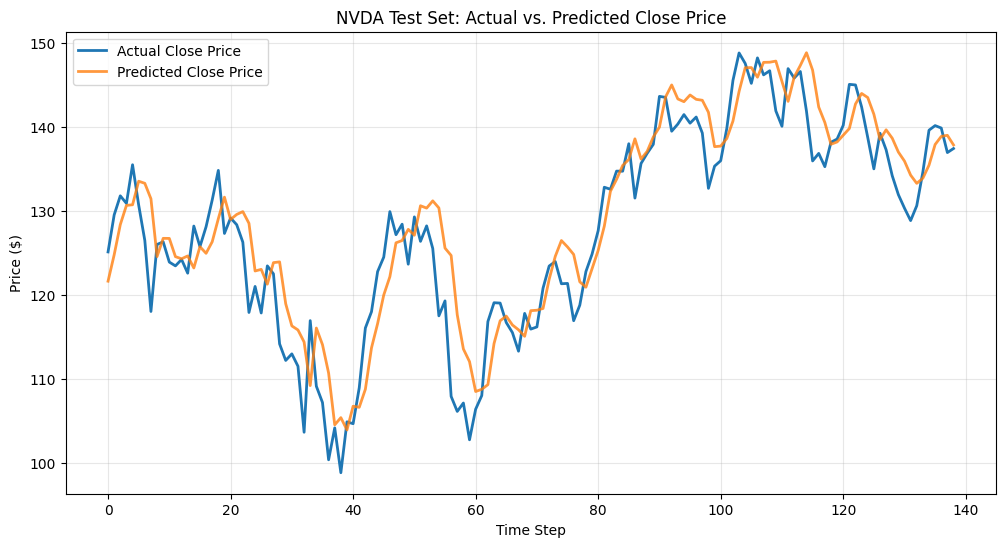

In [13]:
# 13) Plot test set actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label='Actual Close Price', linewidth=2)
plt.plot(pred_prices, label='Predicted Close Price', linewidth=2, alpha=0.8)
plt.title(f'{SYMBOL} Test Set: Actual vs. Predicted Close Price')
plt.xlabel('Time Step')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [14]:
# 14) Predict next 30 days
last_seq = scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, len(features))
future_preds = []
last_date = df.index[-1]

for _ in range(FUTURE_DAYS):
    p = best_model.predict(last_seq)[0, 0]
    tmp = np.zeros((1, len(features)))
    tmp[0, features.index('Close')] = p
    price = scaler.inverse_transform(tmp)[0, features.index('Close')]
    future_preds.append(price)
    new_scaled = np.zeros(len(features))
    new_scaled[features.index('Close')] = p
    last_seq = np.concatenate([last_seq[:, 1:, :], new_scaled.reshape(1, 1, -1)], axis=1)

future_dates = [last_date + timedelta(i+1) for i in range(FUTURE_DAYS)]
df_future = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_preds
}).set_index('Date')

print("\nFuture 30-Day Predictions:")
print(df_future.round(2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

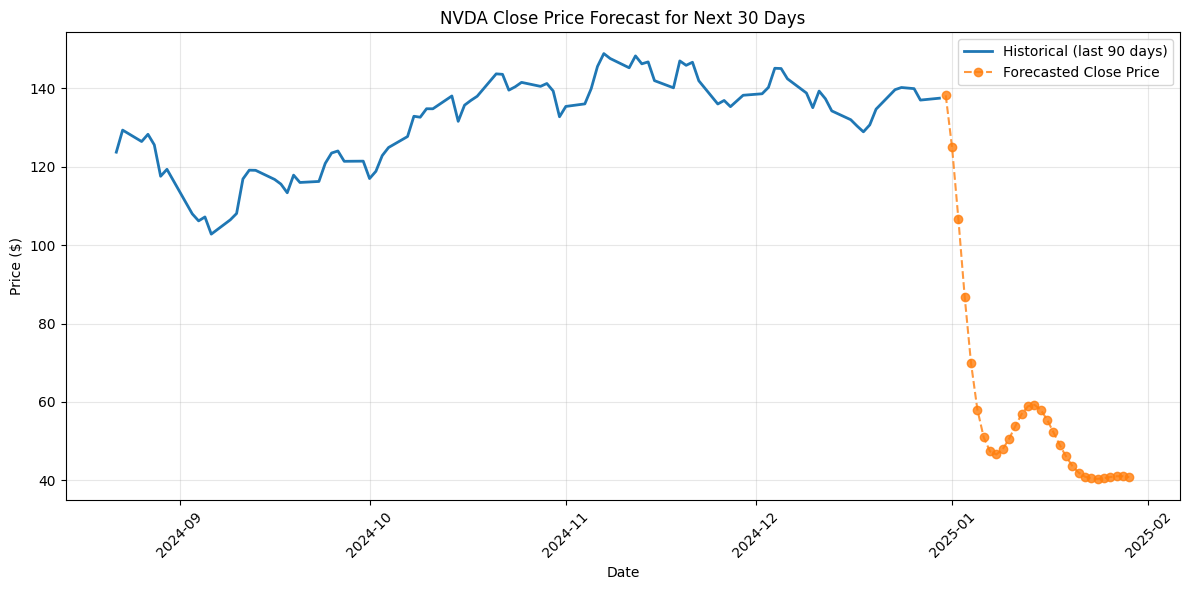

In [15]:
# 15) Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Close'].iloc[-90:], label='Historical (last 90 days)', linewidth=2)
plt.plot(df_future.index, df_future['Predicted_Close'], '--o', label='Forecasted Close Price', alpha=0.8)
plt.title(f'{SYMBOL} Close Price Forecast for Next {FUTURE_DAYS} Days')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()